In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sm = xr.open_mfdataset("data/SMrz/SMrz_*.nc", combine="by_coords")

In [3]:
sm

<xarray.Dataset> Size: 7GB
Dimensions:  (time: 264, lat: 1800, lon: 3600)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-31 2003-02-28 ... 2024-12-31
  * lat      (lat) float64 14kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.7 179.8 179.9
Data variables:
    SMrz     (time, lat, lon) float32 7GB dask.array<chunksize=(4, 600, 1200), meta=np.ndarray>
Attributes:
    Dataset:      Global Land Evaporation Amsterdam Model
    Version:      4.2b
    Authors:      Hydro-Climate Extremes Lab (H-CEL)
    Institution:  Ghent University
    Contact:      info@gleam.eu
    Reference1:   Miralles, D.G. et al. 2011: Global land-surface evaporation...
    Reference2:   Miralles, D. G., Bonte, O., Koppa, A., Baez-Villanueva, O. ...

In [4]:
# resample to land mask
land_mask = xr.open_dataset("data/Land_mask.nc")
land_mask

<xarray.Dataset> Size: 1MB
Dimensions:    (lat: 720, lon: 1440)
Coordinates:
  * lat        (lat) float64 6kB 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon        (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
    time       datetime64[ns] 8B ...
Data variables:
    land_mask  (lat, lon) bool 1MB ...

In [7]:
sm_resampled = sm.interp(
    lat=land_mask.lat, lon=land_mask.lon, time=sm.time, method="nearest"
)
sm_resampled

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 264, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-31 2003-02-28 ... 2024-12-31
  * lat      (lat) float64 6kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    SMrz     (time, lat, lon) float32 1GB dask.array<chunksize=(264, 15, 85), meta=np.ndarray>
Attributes:
    Dataset:      Global Land Evaporation Amsterdam Model
    Version:      4.2b
    Authors:      Hydro-Climate Extremes Lab (H-CEL)
    Institution:  Ghent University
    Contact:      info@gleam.eu
    Reference1:   Miralles, D.G. et al. 2011: Global land-surface evaporation...
    Reference2:   Miralles, D. G., Bonte, O., Koppa, A., Baez-Villanueva, O. ...

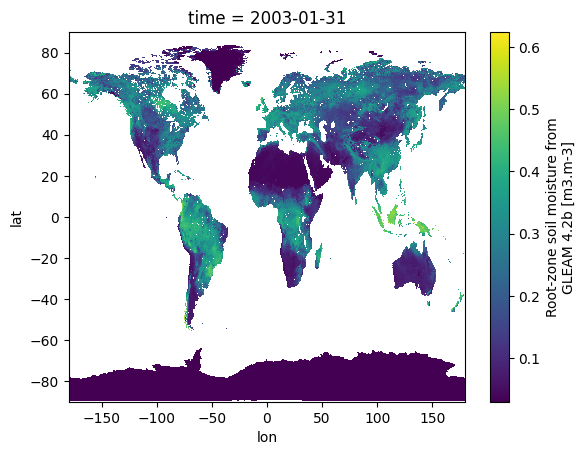

In [8]:
sm_resampled.isel(time=0).SMrz.plot()

In [14]:
sm_resampled = sm_resampled.assign_coords(
    time=pd.date_range("2003-01-01", "2024-12-01", freq="MS")
)

In [12]:
# compare 4.2a and 4.2b
sm_a = xr.open_dataset(
    "data/GLEAM4_sm_0.25deg_monthly_198001-202312.nc", decode_times=False
).assign_coords(time=pd.date_range("1980-01-01", "2023-12-01", freq="MS"))
sm_a

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 528, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2023-12-01
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    sm       (time, lat, lon) float32 2GB ...
Attributes:
    source:   Generated by BogangDong

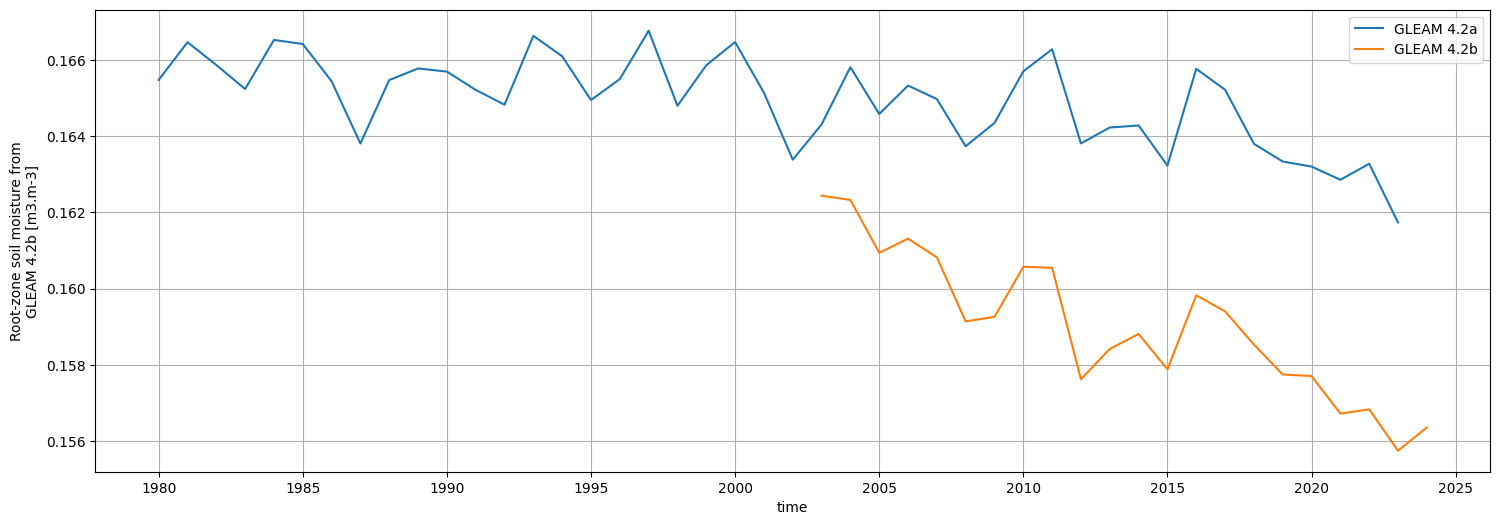

In [17]:
fig, ax = plt.subplots(figsize=(18, 6))
(sm_a["sm"].mean(dim=["lat", "lon"]).resample(time="YS").mean()).plot(
    ax=ax, label="GLEAM 4.2a"
)
(sm_resampled["SMrz"].mean(dim=["lat", "lon"]).resample(time="YS").mean()).plot(
    ax=ax, label="GLEAM 4.2b"
)
ax.grid()
ax.legend()

In [18]:
sm_resampled.to_netcdf("data/GLEAM4.2b_SMrz_resampled.nc")

In [19]:
sm_b = xr.open_dataset("data/GLEAM4.2b_SMrz_resampled.nc")
sm_b

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 264, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2003-01-01 2003-02-01 ... 2024-12-01
  * lat      (lat) float64 6kB 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    SMrz     (time, lat, lon) float32 1GB ...
Attributes:
    Dataset:      Global Land Evaporation Amsterdam Model
    Version:      4.2b
    Authors:      Hydro-Climate Extremes Lab (H-CEL)
    Institution:  Ghent University
    Contact:      info@gleam.eu
    Reference1:   Miralles, D.G. et al. 2011: Global land-surface evaporation...
    Reference2:   Miralles, D. G., Bonte, O., Koppa, A., Baez-Villanueva, O. ...

Text(0.5, 1.0, 'Global Mean Soil Moisture Comparison between GLEAM 4.2a and 4.2b')

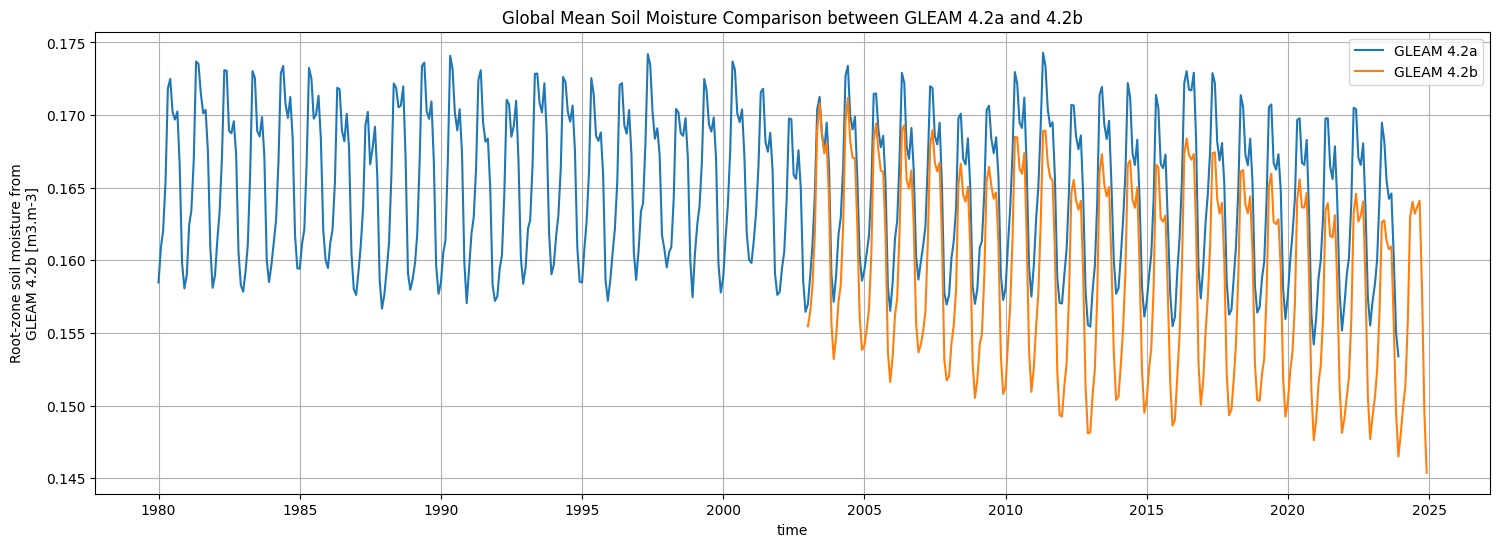

In [24]:
fig, ax = plt.subplots(figsize=(18, 6))
(sm_a["sm"].mean(dim=["lat", "lon"]).resample(time="MS").mean()).plot(
    ax=ax, label="GLEAM 4.2a"
)
(sm_b["SMrz"].mean(dim=["lat", "lon"]).resample(time="MS").mean()).plot(
    ax=ax, label="GLEAM 4.2b"
)
ax.grid()
ax.legend()
ax.set_title("Global Mean Soil Moisture Comparison between GLEAM 4.2a and 4.2b")

Text(0.5, 1.0, 'Tropical Land Mean Soil Moisture Comparison')

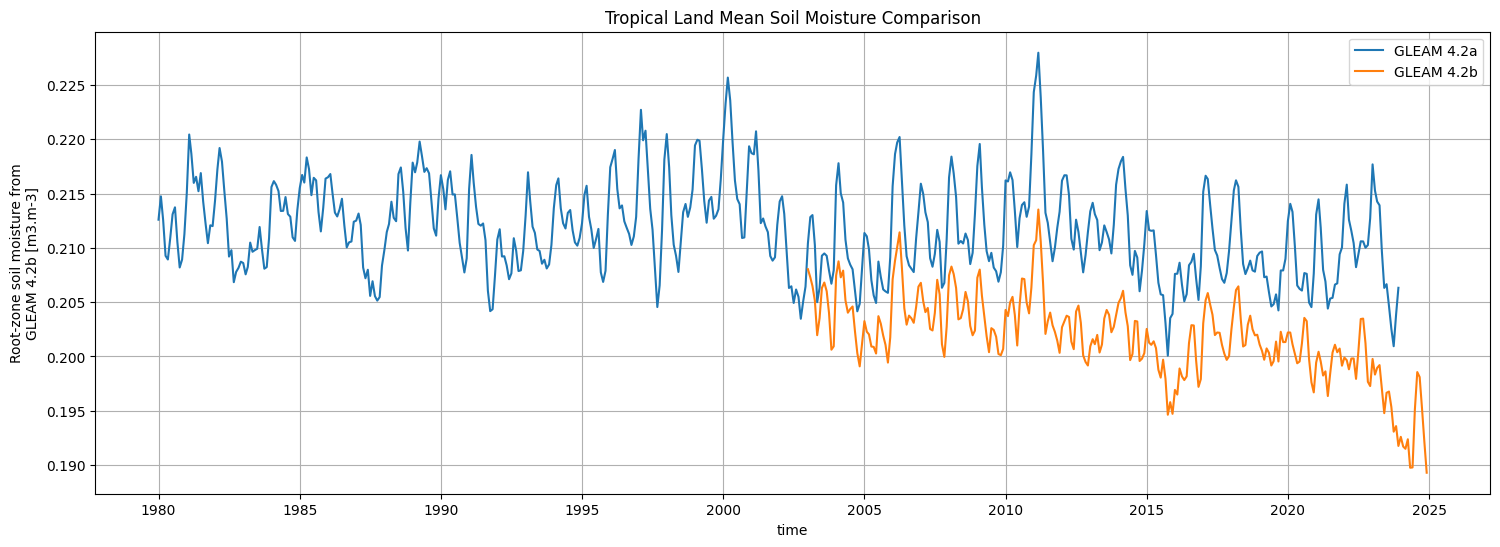

In [23]:
fig, ax = plt.subplots(figsize=(18, 6))
(
    sm_a["sm"]
    .sel(lat=slice(-30, 30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="GLEAM 4.2a")
(
    sm_b["SMrz"]
    .sel(lat=slice(30, -30))
    .mean(dim=["lat", "lon"])
    .resample(time="MS")
    .mean()
).plot(ax=ax, label="GLEAM 4.2b")
ax.grid()
ax.legend()
ax.set_title("Tropical Land Mean Soil Moisture Comparison")